In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine=create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(autoload_with=engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
first_date=session.query(Measurement).order_by(sqlalchemy.desc(Measurement.date)).first().date
print(first_date)

2017-08-23


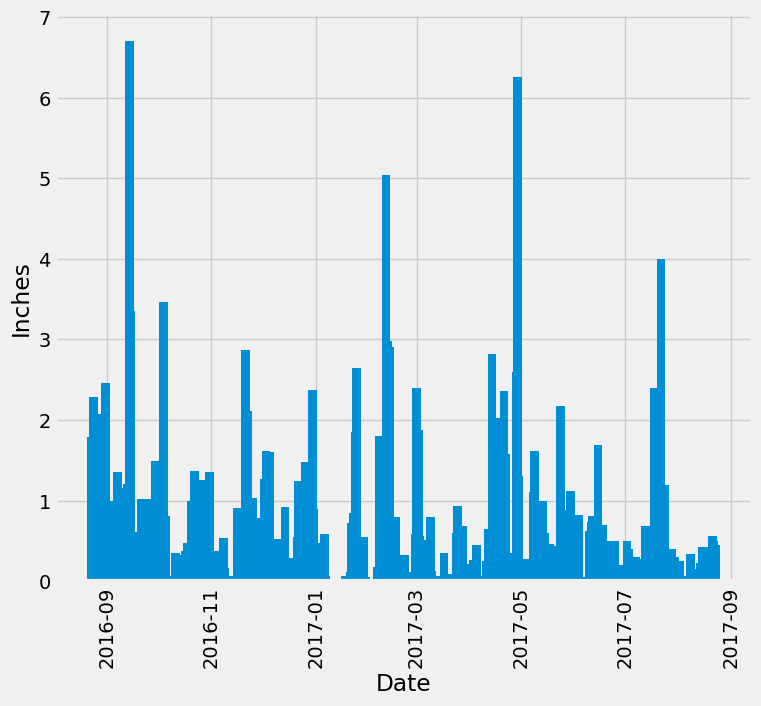

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent=session.query(Measurement).order_by(sqlalchemy.desc(Measurement.date)).first().date
most_recent=dt.datetime.strptime(most_recent,'%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
one_year_ago=most_recent-dt.timedelta(days=1*365)
# Perform a query to retrieve the data and precipitation scores
data=session.query(Measurement).filter(Measurement.date>=one_year_ago)\
    .with_entities(Measurement.date,Measurement.prcp)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
datadf=pd.DataFrame(data,columns=['date','precipitation'])
# datadf['year_month']='%s_%s'%(datadf['date'].year,datadf['date'].month)
# Sort the dataframe by date
datadf=datadf.sort_values(by=['date'])
datadf=datadf.dropna(how='any')
plotdata=datadf.copy()
# plotdata=plotdata.set_index('date')
plotdata=plotdata.groupby('date').max()
plotdata=plotdata.reset_index()
# create plot
x=np.asarray(plotdata['date'], dtype='datetime64')
y=plotdata['precipitation']
fig,ax=plt.subplots(figsize=(8,7))
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
plt.xticks(rotation=90)
ax.bar(x,y,width=5);

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
datadf.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(Station).with_entities(Station.id).count()
print(station_count)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations=session.query(Measurement.station,func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc())
for s in stations:
    print(s)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id=stations[0][0]
ma_temps=session.query(Measurement)\
.filter(Measurement.station==most_active_id)\
.with_entities(Measurement.tobs)
ma_df=pd.DataFrame(ma_temps,columns=['temperature'])
lowest=ma_df['temperature'].min()
highest=ma_df['temperature'].max()
average=ma_df['temperature'].mean()
print('lowest: ',lowest)
print('highest: ',highest)
print('average: ',average)

lowest:  54.0
highest:  85.0
average:  71.66378066378067


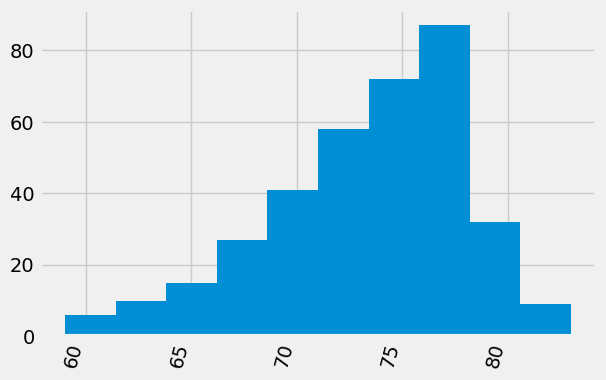

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
ma_most_recent=session.query(Measurement)\
.filter(Measurement.station==most_active_id)\
.order_by(sqlalchemy.desc(Measurement.date)).first().date
ma_most_recent=dt.datetime.strptime(ma_most_recent,'%Y-%m-%d').date()
# print(ma_most_recent)
ma_one_year_ago=ma_most_recent-dt.timedelta(days=1*365)
# print(ma_one_year_ago)
ma_dates_temps=session.query(Measurement)\
.filter(Measurement.station==most_active_id)\
.filter(Measurement.date>=ma_one_year_ago)\
.with_entities(Measurement.date,Measurement.tobs)
ma_dt_df=pd.DataFrame(ma_dates_temps)
fig,ax=plt.subplots()
width=1
ax.hist(ma_dt_df['tobs'])
fig.autofmt_xdate()
plt.setp(ax.get_xticklabels(), rotation = 75)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()